In [1]:
# Assignment : A6
# Mohammed Intekhab : 2018AD04076
# Ajay Sharma       : 2018AD04064
# Avinash Chandra   : 2018AD04061

In [2]:
## Importing libraries for data processing 
import pandas  as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline 

In [3]:
## Import the dataset for inspecting following tasks
## 1. 
jobDataframe = pd.read_csv('data.csv')
print('Row count before dropping Duplicates ',jobDataframe.shape[0])
jobDataframe.drop_duplicates(inplace=True,keep='first')
print('Row count after dropping Duplicates ',jobDataframe.shape[0])

Row count before dropping Duplicates  3228
Row count after dropping Duplicates  3193


In [4]:
## Gives essential information about the dataset
## 1. columns datatypes
## 2. column names
## 3. columns with missing values
## 4. Shape of the dataframe
## 5. Count of missing values per column
def quick_analysis(df):
    print("Data Types:")
    print(df.dtypes)
    print("Columns:")
    print(df.columns)
    print("Columns With Missing Values:")
    cols_with_missing = [col for col in df.columns if df[col].isnull().any()]
    print(cols_with_missing)
    print("Rows and Columns:")
    print(df.shape)
    print("Count of missing values per column:")
    missing_val_count_by_column = (df.isnull().sum())
    print(missing_val_count_by_column)

In [5]:
quick_analysis(jobDataframe)

Data Types:
Job ID                             int64
Agency                            object
Posting Type                      object
# Of Positions                     int64
Business Title                    object
Civil Service Title               object
Title Code No                     object
Level                             object
Job Category                      object
Full-Time/Part-Time indicator     object
Salary Range From                float64
Salary Range To                  float64
Salary Frequency                  object
Work Location                     object
Division/Work Unit                object
Job Description                   object
Minimum Qual Requirements         object
Preferred Skills                  object
Additional Information            object
To Apply                          object
Hours/Shift                       object
Work Location 1                   object
Recruitment Contact              float64
Residency Requirement             object
Post

In [6]:
## Clean up column names for easy of access
## Replace dirty column name with colum names given in metadata.json
import os
import sys
import json
import codecs

inpFileName = 'metadata.json'
column_rename_dict = {}
try:
    metafile = codecs.open(inpFileName,mode='r',encoding='utf-8')
    for line in metafile:
        doc = json.loads(line)
        for elem in doc['columns']:
            column_rename_dict[elem['name']] = elem['fieldName'].replace(" ","")
    metafile.close()
except IOError as e:
    print ("I/O error({0}): {1}".format(e.errno, e.strerror))
except UnicodeEncodeError as err:
    print ('Error :' , err)
except ValueError as err:
    print ('Error :' , err)
    print ("Could not convert data to an integer.")
except:
    print ("Unexpected error:", sys.exc_info()[0])

jobDataframe.rename(columns=column_rename_dict, inplace=True)
print(jobDataframe.columns)

Index(['job_id', 'agency', 'posting_type', '__of_positions', 'business_title',
       'civil_service_title', 'title_code_no', 'level', 'job_category',
       'full_time_part_time_indicator', 'salary_range_from', 'salary_range_to',
       'salary_frequency', 'work_location', 'division_work_unit',
       'job_description', 'minimum_qual_requirements', 'preferred_skills',
       'additional_information', 'to_apply', 'hours_shift', 'work_location_1',
       'recruitment_contact', 'residency_requirement', 'posting_date',
       'post_until', 'posting_updated', 'process_date'],
      dtype='object')


In [8]:
jobDataframe.describe()

,job_id,__of_positions,salary_range_from,salary_range_to,recruitment_contact
count,3193.000000,3193.000000,3193.000000,3193.000000,0.0
mean,373256.673974,2.476041,57244.342124,84126.095689,NaN
std,46797.276901,7.796327,26799.673562,43938.661122,NaN
min,87990.000000,1.000000,0.000000,10.360000,NaN
25%,373353.000000,1.000000,47450.000000,60447.000000,NaN
50%,392237.000000,1.000000,57125.000000,80000.000000,NaN
75%,399773.000000,1.000000,71159.000000,105000.000000,NaN
max,406986.000000,150.000000,218587.000000,234402.000000,NaN


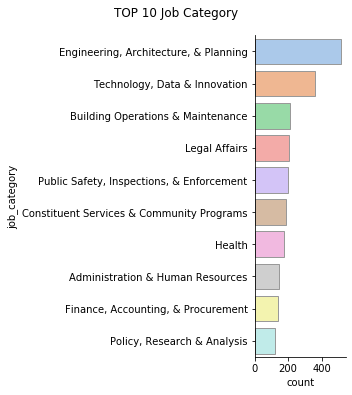

In [9]:
## Top ten job categories
ax = sns.catplot(y="job_category", kind="count",
            palette="pastel", edgecolor=".6",
            data=jobDataframe,order=pd.value_counts(jobDataframe['job_category']).iloc[:10].index);
ax.fig.suptitle("TOP 10 Job Category",y=1.05)
plt.show()

<Figure size 720x720 with 0 Axes>

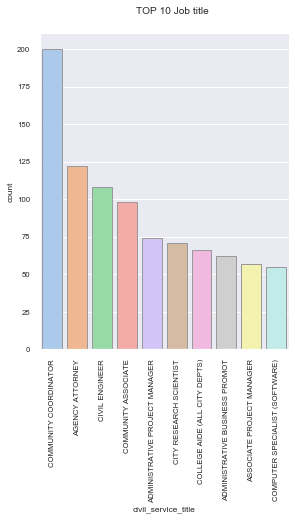

In [10]:
## Top ten job title based on colummn civil_service_title
plt.figure(figsize=(10, 10))
sns.set(font_scale=0.7)
ax = sns.catplot(x="civil_service_title", kind="count",
            palette="pastel", edgecolor=".6",
            data=jobDataframe,order=pd.value_counts(jobDataframe['civil_service_title']).iloc[:10].index);
ax.fig.suptitle("TOP 10 Job title",y=1.05)
plt.xticks(rotation=90)
plt.show()

In [11]:
## Primary Data analysis is based on column 'job_category'
## Drop rows for the data for which the job_category is NULL.
print(jobDataframe.shape)
print("No. of rows with null job_category", jobDataframe[jobDataframe['job_category'].isnull()].shape[0])
jobDataframe.dropna(axis=0 , subset=['job_category'],how='any',inplace=True)
print(jobDataframe.shape)

(3193, 28)
No. of rows with null job_category 2
(3191, 28)


In [12]:
## fix the columns posting_date, posting_updated, process_date to datetime datatype from object type
## ds[["Posting Date"]] = ds[["Posting Date"]].apply(pd.to_datetime)
jobDataframe[["posting_date"]] = jobDataframe[["posting_date"]].apply(pd.to_datetime)
jobDataframe[["posting_updated"]] = jobDataframe[["posting_updated"]].apply(pd.to_datetime)
jobDataframe[["process_date"]] = jobDataframe[["process_date"]].apply(pd.to_datetime)

In [13]:
###Extracting years of experience for each job category:
### Algorithm used 
### 1. Use the minimum_qual_requirements attribute
###    a. pass it through sentence tokenizer
###    b. for each sentence check if the sentence has the word experience along with words (year|month)
###    c. keep the first sentence which match criteria b and discard the rest.
###    d. Extract from the sentence number or text representing number

In [16]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from nltk.util import bigrams
from collections import Counter
#nltk.download()
import re
import itertools
punctuation = re.compile(r'[-.?!,":;()|0-9]')
english_stops = set(stopwords.words('english'))

In [17]:
def getExperience(rawtext):
    wordtonum = ['zero','one','two','three','four','five','six','seven','eight','nine','ten','eleven','twelve',\
             'thirteen','fourteen','fifteen','sixteen','seventeen','eighteen','nineteen','twenty']
    sentence_token = sent_tokenize(str(rawtext))
    for elem in sentence_token:
        if re.search(r'.+experience*',elem):
            tokenize = word_tokenize(elem)
            for token in tokenize:
                if token.lower() in wordtonum:
                    return wordtonum.index(token.lower()) 
            break
    return None

In [18]:
jobDataframe['experience'] = jobDataframe['minimum_qual_requirements'].apply(getExperience)
##Imputing the missing values with median
jobDataframe['experience'] = jobDataframe['experience'].fillna(jobDataframe['experience'].median())
## chek for any missing values in experience column
jobDataframe['experience'].isnull().sum()

0

In [19]:
## Checking columns for missing values
## columns currently missing values are 
missing_val_count_by_column = (jobDataframe.isnull().sum())
print(missing_val_count_by_column[missing_val_count_by_column > 0])

full_time_part_time_indicator     284
minimum_qual_requirements          14
preferred_skills                  419
additional_information           1273
hours_shift                      2140
work_location_1                  1731
recruitment_contact              3191
post_until                       2225
dtype: int64


In [7]:
#########################################################################################################
##                                     Basic Column Analysis                                           ##
#########################################################################################################
## a. Column "Recruitment Contact" can be dropped as values are missing for all rows.
## b. Remove Column "Title Code No" as that information is captured in column "Civil Service Title" and column
##    "Civil Service Title" is self explanatory 
## c. Missing values column names  and how to handle them 
##     1. Job Category                    ( drop rows with missing job_category)
##     2. full_time_part_time_indicator   ( categorical variable simple imputation)
##     3. Minimum Qual Requirements       ( can be dropped as extracted experience)
##     4. Additional Information          ( can be dropped descriptive columns)
##     5. To Apply                        ( can be dropped descriptive columns)
##     6. Hours/Shift                     ( can be dropped descriptive columns)
##     7. Work Location 1                 ( can be dropped descriptive columns)
##     8. Recruitment Contact             ( can be dropped descriptive columns)
##     9. Post Until                      ( can be dropped missing more than half the values)
#########################################################################################################
## Variable Type                          ##                  Feature Name                             ##
#########################################################################################################
### Numerical continuous                  ##             salary_range_from,salary_range_to             ##
### Numerical Discrete                    ##             __of_positions                                ##
### Categorical Binary                    ##             full_time_part_time_indicator, posting_type   ##
### Ordinal data                          ##             salary_frequency, level                       ##
### Interval scaled                       ##             posting_date, posting_updated, process_date   ##
### Categorical Nominal data              ##             agency, business_title, civil_service_title,  ##
###                                       ##             job_category, division_work_unit              ##
#########################################################################################################

In [20]:
##Cannot drop column preferred_skills as it's need for extracting skills
print("Shape Before Dropping columns", jobDataframe.shape[1])
drop_col_list = [ 'title_code_no','job_description', \
                  'additional_information', 'to_apply', 'hours_shift', 'work_location_1', \
                  'recruitment_contact', 'residency_requirement','post_until','minimum_qual_requirements']
jobDataframe.drop(drop_col_list, axis=1,inplace=True)
print("Shape after Dropping columns", jobDataframe.shape[1])

Shape Before Dropping columns 29
Shape after Dropping columns 19


In [21]:
## full_time_part_time_indicator is a categorical Binary variable with values F or P

from sklearn import preprocessing
from sklearn_pandas import CategoricalImputer    ## Need to have this library <pip install sklearn-pandas>

# Preprocessing for categorical data
cat_imputer = CategoricalImputer()
cat_imputer.fit(jobDataframe['full_time_part_time_indicator'])
jobDataframe['full_time_part_time_indicator'] = cat_imputer.transform(jobDataframe['full_time_part_time_indicator'])

In [22]:
## Splitting the dataset based on salary_frequency.
## there is no reliable data to convert salary from one frequency to another
print("Unique Salary frequencies : ",jobDataframe['salary_frequency'].unique())
annual_df = jobDataframe[jobDataframe.salary_frequency == 'Annual'].copy()
hourly_df = jobDataframe[jobDataframe.salary_frequency == 'Hourly'].copy()
daily_df  = jobDataframe[jobDataframe.salary_frequency == 'Daily'].copy()

Unique Salary frequencies :  ['Annual' 'Hourly' 'Daily']


In [23]:
def salary_based_on_job_category(df,avgtype):
    avg_exp = df['experience'].median()
    avg_salary_range = 0 
    min_salary = 0
    max_salary = 0
    if avgtype == 'mean':
        min_salary=df['salary_range_from'].mean()
        max_salary=df['salary_range_to'].mean()
    elif avgtype == 'median':
        min_salary=df['salary_range_from'].median()
        max_salary=df['salary_range_to'].median()
    else:
        min_salary=0
        max_salary=0
    avg_salary_range = max_salary - min_salary    
    return [min_salary,max_salary,avg_exp,avg_salary_range]

In [24]:
##Create function which takes input as a dataframe , ouputs a dictonary with 
## key as job_category and value as a list with two element:  average salary_range_from and salary_range_to
## the average can be done based on mean or median
## the average experience (median)
## salary range = salary_range_to - salary_range_from
def getSalaryRangeFromTo_perJobCategory(df,avgtype):
    job_category = {}
    for elem in df['job_category'].unique():
        job_category[elem] = 0
    for key in job_category.keys():
        #print("key :" ,key)
        #print("Value list ",salary_based_on_job_category(df[df.job_category==key]))
        job_category[key]= salary_based_on_job_category(df[df.job_category==key],avgtype)
    return job_category

In [ ]:
## There are certain job categories which have multiple salary frequency and the salary are also 
## according to the salary frequency. Example below
## Clustering should be as implemented by splitting the dataset on salary frequency to avoid 
## salary range bias.
###########################################################################################
##    job_category                                              ## Salary_frequency      ##
###########################################################################################
##    Maintenance & Operations                                  ## Annual, Hourly        ##
##    Clerical & Administrative Support                         ## Annual, Hourly        ##
##    Engineering, Architecture, & Planning                     ## Annual, Hourly, Daily ##
###########################################################################################

## We have already split the dataframe horizontally based on salary frequency 
## annual_df , hourly_df , daily_df 

In [27]:
avgtype = "median"
annual_salary_job = pd.DataFrame.from_dict(getSalaryRangeFromTo_perJobCategory(annual_df,avgtype),\
                                           orient='index',\
                                           columns=['avg_salary_range_from', 'avg_salary_range_to',\
                                                    'avg_exp','avg_salary_range'])

daily_salary_job = pd.DataFrame.from_dict(getSalaryRangeFromTo_perJobCategory(daily_df,avgtype),\
                                           orient='index',\
                                           columns=['avg_salary_range_from', 'avg_salary_range_to',\
                                                    'avg_exp','avg_salary_range'])
hourly_salary_job = pd.DataFrame.from_dict(getSalaryRangeFromTo_perJobCategory(hourly_df,avgtype),\
                                           orient='index',\
                                           columns=['avg_salary_range_from', 'avg_salary_range_to',\
                                                    'avg_exp','avg_salary_range'])

In [37]:
find_max_salary = annual_salary_job['avg_salary_range_to'].max()
job_val = annual_salary_job[annual_salary_job['avg_salary_range_to']==find_max_salary].index.tolist()
print ("Annual Salary Frequency highest Salary jobs",job_val)
find_max_salary = daily_salary_job['avg_salary_range_to'].max()
job_val = daily_salary_job[daily_salary_job['avg_salary_range_to']==find_max_salary].index.tolist()
print ("Daily Salary Frequency highest Salary jobs",job_val)
find_max_salary = hourly_salary_job['avg_salary_range_to'].max()
job_val = hourly_salary_job[hourly_salary_job['avg_salary_range_to']==find_max_salary].index.tolist()
print ("Hourly Salary Frequency highest Salary jobs",job_val)

Annual Salary Frequency highest Salary jobs ['Communications & Intergovernmental Affairs Legal Affairs Policy, Research & Analysis']
Daily Salary Frequency highest Salary jobs ['Engineering, Architecture, & Planning']
Hourly Salary Frequency highest Salary jobs ['Engineering, Architecture, & Planning Technology, Data & Innovation Policy, Research & Analysis', 'Finance, Accounting, & Procurement Policy, Research & Analysis Social Services']


In [ ]:
## The Highest paying jobs for different salary_frequency are as follows:

######################################################################################################################
##  Salary_Frequency   ##                               Job Category                                                ##
######################################################################################################################
##    Annual          ## a.Communications & Intergovernmental Affairs Legal Affairs Policy Research & Analysis      ##      
######################################################################################################################
##    Daily           ## a.Engineering, Architecture, & Planning                                                    ##
######################################################################################################################
##    Hourly          ## a.Engineering, Architecture, & Planning Technology,                                        ##
##                         Data & Innovation Policy, Research & Analysis                                            ##
##                    ## b.Finance, Accounting, & Procurement Policy, Research & Analysis Social Services           ##
######################################################################################################################

In [ ]:
sentences = [sent_tokenize(str(val)) for val in annual_df.preferred_skills]
sentences_flat_list = list(itertools.chain(*sentences))
tokenized_sent = [word_tokenize(sentence) for sentence in sentences_flat_list]
tokenized_flat_list = list(itertools.chain(*tokenized_sent))
# Convert the tokens into lowercase: lower_tokens
lower_tokens = [t.lower() for t in tokenized_flat_list]
# Retain alphabetic words: alpha_only
alpha_only = [t for t in lower_tokens if t.isalpha()]
# Remove all stop words: no_stops
no_stops = [t for t in alpha_only if t not in english_stops]

In [ ]:
tokens_pos_tag = nltk.pos_tag(no_stops)
filtered_pos = [ ]
for one in tokens_pos_tag:
    if one[1] == 'NN' or one[1] == 'NNS' or one[1] == 'NNP' or one[1] == 'NNPS':
        filtered_pos.append(one)
fdist_pos = nltk.FreqDist(filtered_pos)
top_100_words = fdist_pos.most_common()

In [51]:
## Cluster Analysis
from scipy.cluster.hierarchy import fcluster,linkage,dendrogram
from scipy.cluster.vq import whiten
annual_salary_job['scaled_avg_salary_range'] = whiten(annual_salary_job['avg_salary_range'])
annual_salary_job['scaled_avg_exp']          = whiten(annual_salary_job['avg_exp'])
daily_salary_job['scaled_avg_salary_range']  = whiten(daily_salary_job['avg_salary_range'])
daily_salary_job['scaled_avg_exp']           = whiten(daily_salary_job['avg_exp'])
hourly_salary_job['scaled_avg_salary_range'] = whiten(hourly_salary_job['avg_salary_range'])
hourly_salary_job['scaled_avg_exp']          = whiten(hourly_salary_job['avg_exp'])

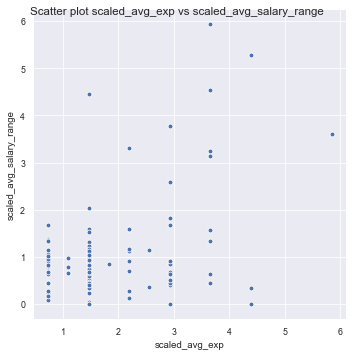

In [81]:
##To get a sense of Annual frequency clusters 
##Plot the two columns in a scatter plot
sns.set_style("darkgrid")
sns.set_context("paper")
g = sns.relplot(x="scaled_avg_exp", y="scaled_avg_salary_range", data=annual_salary_job,kind="scatter")
g.fig.suptitle("Scatter plot scaled_avg_exp vs scaled_avg_salary_range")
plt.show()

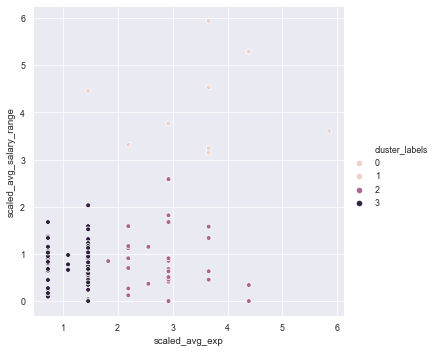

In [82]:
# Use the linkage() function , ward method and euclidean distance
distance_matrix = linkage(annual_salary_job[['scaled_avg_exp', 'scaled_avg_salary_range']], \
                          method = 'ward', metric = 'euclidean')
annual_salary_job['cluster_labels'] = fcluster(distance_matrix, 3 , criterion='maxclust')
# Plot clusters
ax = sns.relplot(x='scaled_avg_exp', y='scaled_avg_salary_range', 
                hue='cluster_labels', data = annual_salary_job,kind="scatter")
g.fig.suptitle("Scatter plot scaled_avg_exp vs scaled_avg_salary_range grouped by cluster")
plt.show()

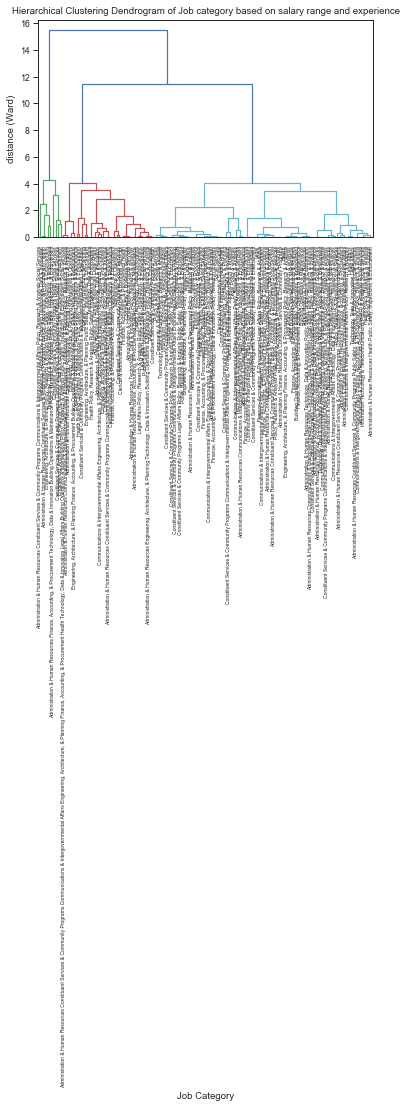

In [76]:
plt.title('Hierarchical Clustering Dendrogram of Job category based on Annual freq salary range and experience')
plt.xlabel('Job Category')
plt.ylabel('distance (Ward)')
dn = dendrogram(distance_matrix, labels=annual_salary_job.index, leaf_rotation=90)
plt.show()

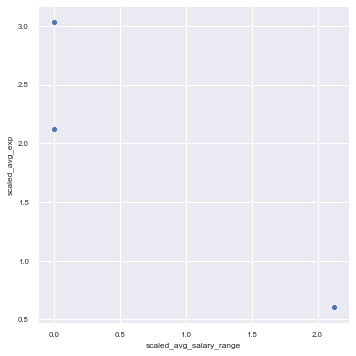

In [46]:
##To get a sense of Daily clusters 
##Plot the two columns in a scatter plot
sns.relplot(x="scaled_avg_salary_range", y="scaled_avg_exp", data=daily_salary_job)
plt.show()
## since there are only 3 data points for daily dataset we can discard it.

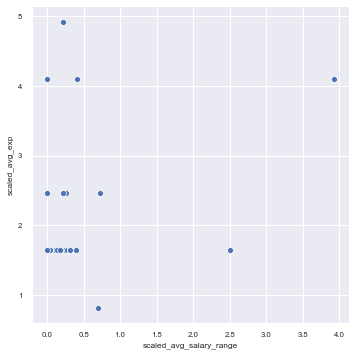

In [47]:
##To get a sense of Hourly clusters 
##Plot the two columns in a scatter plot
sns.relplot(x="scaled_avg_salary_range", y="scaled_avg_exp", data=hourly_salary_job)
plt.show()

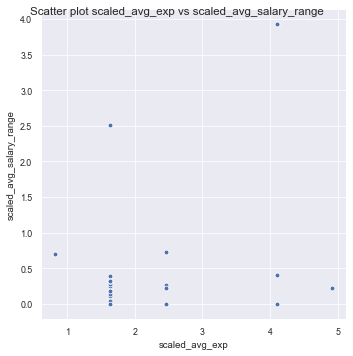

In [83]:
##To get a sense of hourly frequency clusters 
##Plot the two columns in a scatter plot
g= sns.relplot(x="scaled_avg_exp", y="scaled_avg_salary_range", data=hourly_salary_job)
g.fig.suptitle("Scatter plot scaled_avg_exp vs scaled_avg_salary_range")
plt.show()

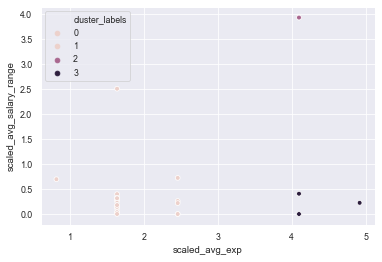

In [84]:
# Use the linkage() function , ward method and euclidean distance
distance_matrix = linkage(hourly_salary_job[['scaled_avg_exp', 'scaled_avg_salary_range']], \
                          method = 'ward', metric = 'euclidean')
hourly_salary_job['cluster_labels'] = fcluster(distance_matrix, 3 , criterion='maxclust')
# Plot clusters
sns.scatterplot(x='scaled_avg_exp', y='scaled_avg_salary_range', 
                hue='cluster_labels', data = hourly_salary_job)
plt.show()

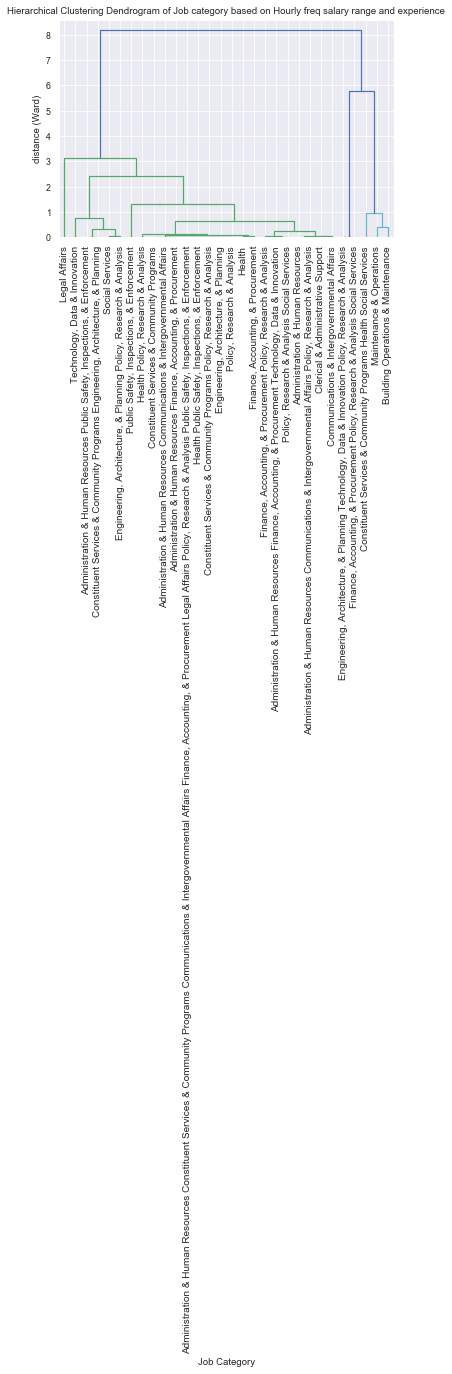

In [85]:
plt.title('Hierarchical Clustering Dendrogram of Job category based on Hourly freq salary range and experience')
plt.xlabel('Job Category')
plt.ylabel('distance (Ward)')
dn = dendrogram(distance_matrix, labels=hourly_salary_job.index, leaf_rotation=90)
plt.show()